In [15]:
from PIL import Image
from pyavm import AVM
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astropy import units as u
import warnings
from reproject import reproject_interp
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 

In [2]:
# input file 
# https://www.eso.org/public/images/eso1920a/ 
inputfile = 'eso1920a.tif' 

In [3]:
# # Find image size
# nx, ny = Image.open(inputfile).size

# # Now convert AVM information to WCS
# data = AVM.from_image(inputfile).to_wcs()

# # Need to scale CDELT values sometimes the AVM meta-data is only
# # really valid for the full-resolution image
# nx_, ny_ = (AVM.from_image(inputfile).to_wcs().wcs.crpix)*2
# data.wcs.cdelt = [data.wcs.cdelt[0] * nx_ / float(nx), data.wcs.cdelt[1] * ny_ / float(ny)]
# data.wcs.crpix = [data.wcs.crpix[0] / nx_ * float(nx), data.wcs.crpix[1] / ny_ * float(ny)]

# # Update the NAXIS values with the true dimensions of the RGB image
# data.nx = nx
# data.ny = ny
# data.pixel_shape = (nx, ny)

def get_scaled_avm_wcs(inputfile):
    """
    Load an RGB TIFF image and return a scaled WCS object from embedded AVM metadata.

    Parameters:
    -----------
    inputfile : str
        Path to the TIFF image.

    Returns:
    --------
    wcs : astropy.wcs.WCS
        WCS object scaled to the image resolution.

    Raises:
    -------
    ValueError if AVM metadata is not found.
    """
    # Get image and size
    image = Image.open(inputfile)
    nx, ny = image.size

    # Load AVM metadata
    avm = AVM.from_image(inputfile)
    if avm is None:
        raise ValueError(f"No AVM metadata found in image: {inputfile}")

    # Convert to WCS
    wcs = avm.to_wcs()

    # Reference resolution (from AVM crpix * 2)
    # Assuming AVM crpix is at the center of the image
    nx_, ny_ = (wcs.wcs.crpix[0] * 2, wcs.wcs.crpix[1] * 2)

    # Rescale WCS
    wcs.wcs.cdelt = [
        wcs.wcs.cdelt[0] * nx_ / float(nx),
        wcs.wcs.cdelt[1] * ny_ / float(ny)
    ]
    wcs.wcs.crpix = [
        wcs.wcs.crpix[0] / nx_ * float(nx),
        wcs.wcs.crpix[1] / ny_ * float(ny)
    ]

    # Optional: attach image shape info to WCS
    wcs.nx = nx
    wcs.ny = ny
    wcs.pixel_shape = (ny, nx)  # Astropy expects (ny, nx) order

    return image, wcs

image, wcs = get_scaled_avm_wcs(inputfile)

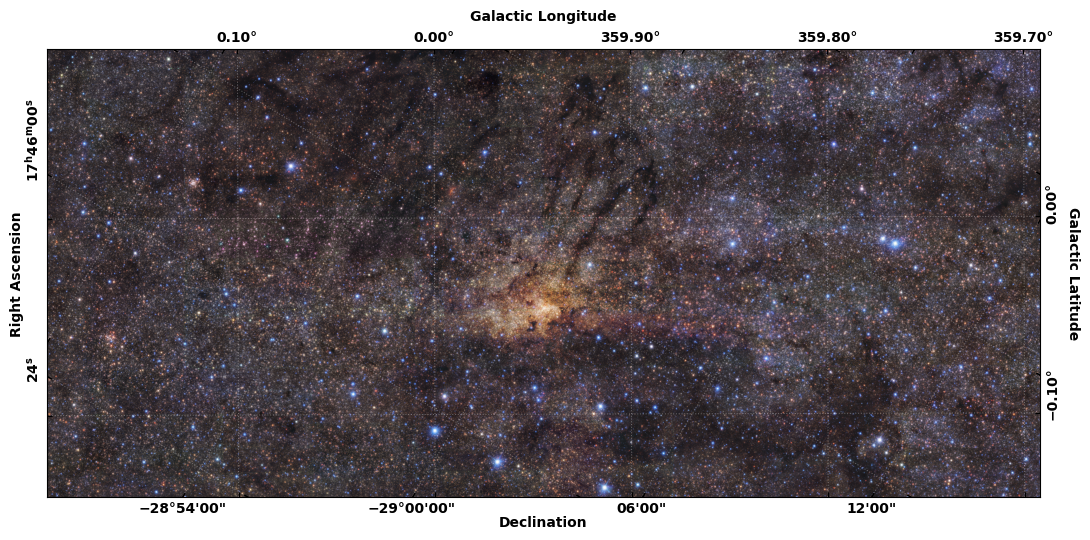

In [56]:
image = Image.open(inputfile)

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111, projection=WCS(wcs.to_header()))
ax.imshow(image, origin='lower')

ax.coords['ra'].set_major_formatter('hh:mm:ss')
ax.coords['dec'].set_major_formatter('dd:mm:ss')
ax.coords['ra'].set_ticks(spacing=0.1 *u.deg)
ax.coords['dec'].set_ticks(spacing=0.1 *u.deg)
ax.coords['ra'].set_ticklabel(rotation='vertical')
ax.coords['ra'].set_axislabel('Right Ascension', minpad=0.5)
ax.coords['dec'].set_axislabel('Declination', minpad=0.5)

ax.grid(color='white', ls='dotted', lw=0.75, alpha=0.3)

overlay = ax.get_coords_overlay('galactic')
overlay['l'].set_axislabel('Galactic Longitude')
overlay['b'].set_axislabel('Galactic Latitude')
overlay['l'].set_major_formatter('d.dd')
overlay['b'].set_major_formatter('d.dd')
overlay['l'].set_ticks(spacing=0.1 *u.deg)
overlay['b'].set_ticks(spacing=0.1 *u.deg)
overlay['b'].set_ticklabel(rotation='vertical')

# SET LIMS
xlims, ylims = [300, np.array(image).shape[1]-300], [100, np.array(image).shape[0]-100]
ax.set_xlim(xlims)
ax.set_ylim(ylims)

overlay.grid(color='white', ls='dotted', lw=0.75, alpha=0.3)
fig.tight_layout()

### - SAVING, but you may want to increase the dpi for a better quality... 
# fig.savefig('galacticnucleus.pdf', dpi=300, transparent=True, bbox_inches='tight')
fig.savefig('galacticnucleus.png', dpi=75, transparent=False, bbox_inches='tight')

In [28]:
hdu_hnco = fits.open('/Users/abarnes/Library/CloudStorage/Dropbox/Data/Galactic/Herschel/HIGAL/tot/gaussfit_iter_beta175_column_gc_itervar_conv25.fits')[0]
data_hnco_reproj = reproject_interp(hdu_hnco, wcs, shape_out=np.array(image).shape[:2], return_footprint=False)
hdu_hnco_reproj = fits.PrimaryHDU(data=data_hnco_reproj, header=wcs.to_header())

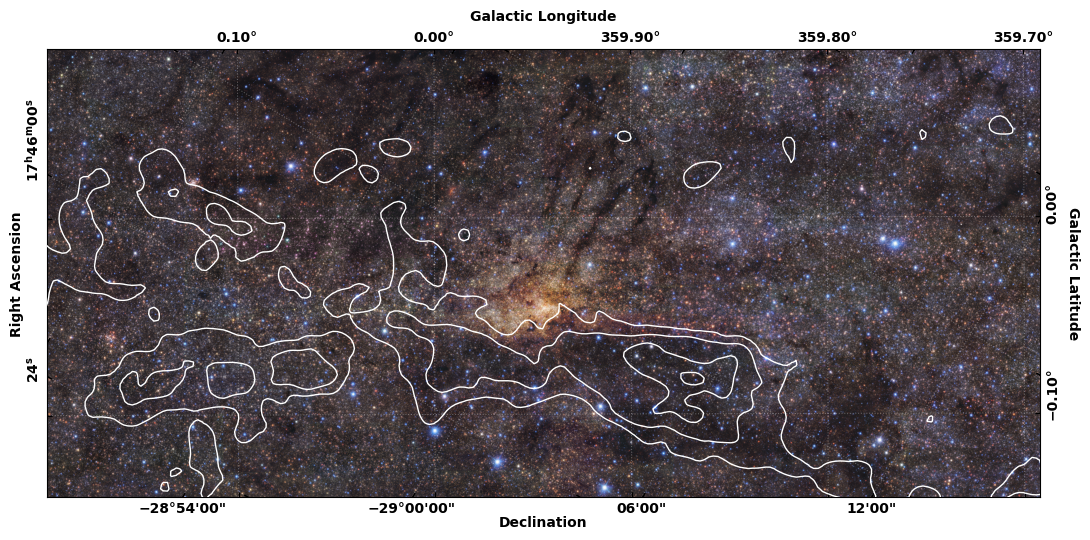

In [57]:
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111, projection=WCS(wcs.to_header()))
ax.imshow(image, origin='lower')
# Column density in units of 10^22 cm^-2
plt.contour(hdu_hnco_reproj.data, levels=[5, 10, 25, 50], linewidths=1, colors='white')

ax.coords['ra'].set_major_formatter('hh:mm:ss')
ax.coords['dec'].set_major_formatter('dd:mm:ss')
ax.coords['ra'].set_ticks(spacing=0.1 *u.deg)
ax.coords['dec'].set_ticks(spacing=0.1 *u.deg)
ax.coords['ra'].set_ticklabel(rotation='vertical')
ax.coords['ra'].set_axislabel('Right Ascension', minpad=0.5)
ax.coords['dec'].set_axislabel('Declination', minpad=0.5)

ax.grid(color='white', ls='dotted', lw=0.75, alpha=0.3)

overlay = ax.get_coords_overlay('galactic')
overlay['l'].set_axislabel('Galactic Longitude')
overlay['b'].set_axislabel('Galactic Latitude')
overlay['l'].set_major_formatter('d.dd')
overlay['b'].set_major_formatter('d.dd')
overlay['l'].set_ticks(spacing=0.1 *u.deg)
overlay['b'].set_ticks(spacing=0.1 *u.deg)
overlay['b'].set_ticklabel(rotation='vertical')

# SET LIMS
xlims, ylims = [300, np.array(image).shape[1]-300], [100, np.array(image).shape[0]-100]
ax.set_xlim(xlims)
ax.set_ylim(ylims)

overlay.grid(color='white', ls='dotted', lw=0.75, alpha=0.3)
fig.tight_layout()

### - SAVING, but you may want to increase the dpi for a better quality... 
# fig.savefig('galacticnucleus.pdf', dpi=300, transparent=True, bbox_inches='tight')
fig.savefig('galacticnucleus_N2H.png', dpi=75, transparent=False, bbox_inches='tight')